# Microsoft Corpotarion (MSFT) Prediction using LSTM

## Context
I'm going to use quote history since they release in Mar 12th of 1986 until Oct 24th of 2022 and use Long-short term memory model (LSTM Model) to predict future quote prices. Dataset can be found on Yahoo Finance where you can access through the following link: https://finance.yahoo.com/quote/MSFT/history/

Long-short term memory is a special kind of recurrent neural network that is capable of learning long term dependencies in data, you can find an article explaining in easy and summary way on Analytcs Vidhya written by Shipra Saxena. 

https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/



## Objective:
Examine/clean the dataset;

Explore dataset distributions features using statistics and plots;

Apply LSTM Neural Networks to forecast next few days

### Import Dependencies

In [ ]:
 import numpy as np
 import pandas as pd
 import matplotlib.pyplot as plt
 %matplotlib inline
 from sklearn.preprocessing import MinMaxScaler
 from tensorflow.keras.models import Sequential, load_model
 from tensorflow.keras.layers import LSTM, Dense, Dropout
 import os
 import tensorflow as tf
 tf.__version__

'2.10.0'

In [ ]:
df = pd.read_csv('MSFT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,3/13/1986,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800,MFST
1,3/14/1986,0.097222,0.102431,0.097222,0.100694,0.063158,308160000,MFST
2,3/17/1986,0.100694,0.103299,0.100694,0.102431,0.064247,133171200,MFST
3,3/18/1986,0.102431,0.103299,0.098958,0.099826,0.062613,67766400,MFST
4,3/19/1986,0.099826,0.100694,0.097222,0.098090,0.061524,47894400,MFST
...,...,...,...,...,...,...,...,...
9225,10/18/2022,243.240005,243.929993,235.369995,238.500000,238.500000,26329600,MFST
9226,10/19/2022,237.039993,239.610001,234.289993,236.479996,236.479996,19985700,MFST
9227,10/20/2022,235.770004,241.309998,234.869995,236.149994,236.149994,21811000,MFST
9228,10/21/2022,234.740005,243.000000,234.500000,242.119995,242.119995,26280900,MFST


Let's only Close quote values and transform to array so we can work with it

In [ ]:
df = df['Close'].values
df = df.reshape(-1,1)
print(df.shape)
df[:5]

(9230, 1)


array([[0.097222],
       [0.100694],
       [0.102431],
       [0.099826],
       [0.09809 ]])

In [ ]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:]) #that 50 is overlap, a few more for prediction later

In [ ]:
dataset_train.shape

(7384, 1)

In [ ]:
dataset_test.shape

(1896, 1)

### Preprocessing the Dataset

Now let's scale our dataset just to make sure our network will run properly. I'll scale quote values in a range between 0 and 1

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.00011676],
       [0.00017514],
       [0.00020435],
       [0.00016055],
       [0.00013136]])

In [ ]:
dataset_test = scaler.transform(dataset_test) # it's interesting to noticed that for my network, dataset_test is unknown, that's why we don't use fit_transform
dataset_test[:5]

array([[0.7073844 ],
       [0.69830451],
       [0.71999533],
       [0.71545538],
       [0.72134053]])

In [ ]:
def create_my_dataset(df):
  x = []
  y = []
  for i in range(50, df.shape[0]):
      x.append(df[i-50:i,0]) # 50-50=0 then start with i
      y.append(df[i,0])
  x = np.array(x)
  y = np.array(y)
  return x,y

In [ ]:
x_train, y_train = create_my_dataset(dataset_train)
print(x_train[:1])
x_train[:1].shape

[[1.16760393e-04 1.75140589e-04 2.04347502e-04 1.60545540e-04
  1.31355442e-04 8.75702946e-05 4.37851473e-05 0.00000000e+00
  2.91900982e-05 7.29752455e-05 1.02165344e-04 8.75702946e-05
  7.29752455e-05 8.75702946e-05 1.02165344e-04 1.02165344e-04
  7.29752455e-05 8.75702946e-05 1.16760393e-04 1.31355442e-04
  1.60545540e-04 1.75140589e-04 1.75140589e-04 2.33537600e-04
  2.48132649e-04 1.89752453e-04 1.89752453e-04 1.60545540e-04
  1.67843065e-04 3.35702944e-04 4.52480151e-04 4.67075200e-04
  4.08678189e-04 3.64893042e-04 3.35702944e-04 3.35702944e-04
  3.21107895e-04 3.35702944e-04 3.35702944e-04 3.50297993e-04
  3.35702944e-04 3.50297993e-04 3.64893042e-04 3.50297993e-04
  3.50297993e-04 3.64893042e-04 3.35702944e-04 3.21107895e-04
  2.91917797e-04 2.91917797e-04]]


(1, 50)

In [ ]:
x_test, y_test = create_my_dataset(dataset_test)
print(x_test[:1])
x_test[:1].shape

[[0.7073844  0.69830451 0.71999533 0.71545538 0.72134053 0.72722559
  0.80339559 0.80608592 0.82508641 0.82340497 0.81634281 0.81667912
  0.80961703 0.79885564 0.77666042 0.78372258 0.80137786 0.79498831
  0.794652   0.79936013 0.81768801 0.81062586 0.80574962 0.79851942
  0.79851942 0.79582902 0.78708551 0.78187296 0.79902384 0.79633351
  0.78641291 0.79263428 0.78742173 0.78624471 0.77800562 0.77430638
  0.76741242 0.76606729 0.78220926 0.77935075 0.77144794 0.76320878
  0.76909391 0.77144794 0.78405887 0.77363378 0.77581971 0.77043905
  0.76589909 0.76606729]]


(1, 50)

### Training LSTM Network

Let's prepare our model adding an amount of 126 neurons in this layers. We may think that the higher the numbers of neurons - layers, it's better, but we have to keep in mind that's is a tradeoff between the time we want to invest in creating the network and the performance of the network. Higher network means more investing time. That's not a rule, but in general this is what happen

In [ ]:
#x_train.shape
#(7334,50,1)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))
print(x_train.shape)
print(x_test.shape)

(7334, 50, 1)
(1846, 50, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=126, return_sequences=True, input_shape=(x_train.shape[1],1))) #first argument is the shape, second is the feature
model.add(Dropout(0.2)) # 20% of all neurons will cut off to avoid overfitting
model.add(LSTM(units=126, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=126))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 126)           64512     
                                                                 
 dropout (Dropout)           (None, 50, 126)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 126)           127512    
                                                                 
 dropout_1 (Dropout)         (None, 50, 126)           0         
                                                                 
 lstm_2 (LSTM)               (None, 126)               127512    
                                                                 
 dropout_2 (Dropout)         (None, 126)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

I'll define the loss and training from next steps, on loss we'll use mean square error because it's a numeric problem and for optmizer we'll use adam. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.

In [ ]:
model.compile(loss = 'mean_squared_error',optimizer='adam')

In [ ]:
if (not os.path.exists(r'C:\Users\f00480153\Desktop\LSTM MICROSOFT PREDICTION\model_stock_prediction')):
  model.fit(x_train,y_train, epochs=50, batch_size=32)
  model.save(r'C:\Users\f00480153\Desktop\LSTM MICROSOFT PREDICTION\model_stock_prediction')

Epoch 1/50
230/230 [==============================] - 21s 91ms/step - loss: 0.0011
Epoch 2/50
230/230 [==============================] - 22s 95ms/step - loss: 9.4819e-04
Epoch 3/50
230/230 [==============================] - 22s 97ms/step - loss: 8.7287e-04
Epoch 4/50
230/230 [==============================] - 23s 99ms/step - loss: 7.7153e-04
Epoch 5/50
230/230 [==============================] - 23s 98ms/step - loss: 6.7913e-04
Epoch 6/50
230/230 [==============================] - 24s 103ms/step - loss: 6.2772e-04
Epoch 7/50
230/230 [==============================] - 25s 107ms/step - loss: 6.4008e-04
Epoch 8/50
230/230 [==============================] - 24s 105ms/step - loss: 5.9784e-04
Epoch 9/50
230/230 [==============================] - 24s 105ms/step - loss: 5.9344e-04
Epoch 10/50
230/230 [==============================] - 25s 107ms/step - loss: 5.5178e-04
Epoch 11/50
230/230 [==============================] - 24s 104ms/step - loss: 5.2615e-04
Epoch 12/50
230/230 [==================

INFO:tensorflow:Assets written to: C:\Users\f00480153\Desktop\LSTM MICROSOFT PREDICTION\model_stock_prediction\assets


INFO:tensorflow:Assets written to: C:\Users\f00480153\Desktop\LSTM MICROSOFT PREDICTION\model_stock_prediction\assets


In [ ]:
model = load_model(r'C:\Users\f00480153\Desktop\LSTM MICROSOFT PREDICTION\model_stock_prediction')

Noticed that our model is scaled, so we need to reverse scaler so our values be the quote values

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions

58/58 [==============================] - 3s 49ms/step


array([[ 45.537987],
       [ 45.218376],
       [ 44.351463],
       ...,
       [184.24132 ],
       [227.02232 ],
       [207.36847 ]], dtype=float32)

range(7384, 9230)


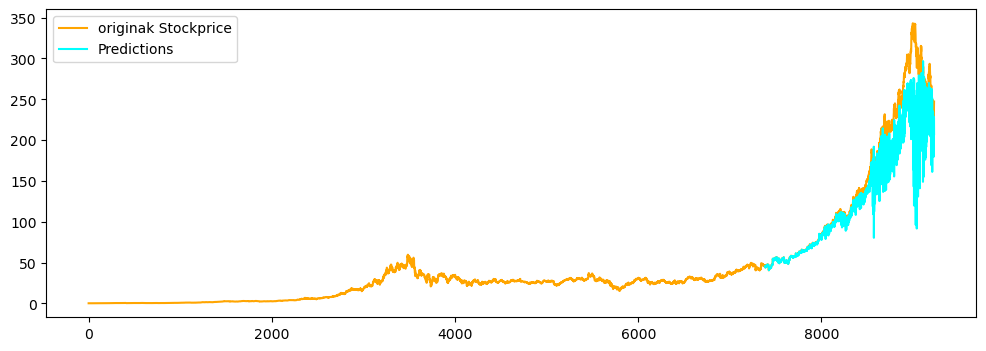

In [ ]:
fig,ax=plt.subplots(figsize=(12,4))
plt.plot(df, color='orange',label='originak Stockprice')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions, color='cyan', label='Predictions')
plt.legend()
print(range(len(y_train)+50, len(y_train)+50+len(predictions)))

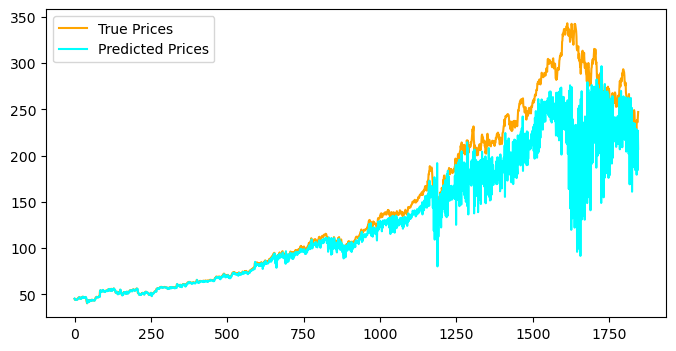

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='orange',label='True Prices')
plt.plot(predictions,color="cyan",label = 'Predicted Prices')
plt.legend()